# Was ist der beliebteste Tag pro Land?

In [1]:
# Import
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path_data = '/home/jm/Desktop/Gamestar_Data/Country_Games/'
path_files = sorted([os.path.join(path_data, file) for file in os.listdir(path_data)])

In [3]:
df = pd.concat([pd.read_csv(file).assign(date=datetime.strptime(file.rsplit('/', 1)[-1].split('_', 1)[0], '%Y-%m-%d')) for file in path_files])

In [4]:
df_country = df.set_index('App_ID').dropna().reset_index().set_index('date')
df_country.shape

(813167, 9)

In [5]:
unique_appids = df_country['App_ID'].unique()
len(unique_appids)

7359

In [6]:
df_api = pd.read_json('/home/jm/Desktop/Gamestar_Data/API/2017-11-01_SteamSpy_API.json').T
df_api.head(2)

,appid,average_2weeks,average_forever,ccu,developer,median_2weeks,median_forever,name,owners,owners_variance,players_2weeks,players_2weeks_variance,players_forever,players_forever_variance,price,publisher,score_rank,tags
10,10,736,11053,19696,Valve,88,414,Counter-Strike,14170391,110949,344712,17560,9969026,93478,999,Valve,97,"{'Action': 2560, 'FPS': 1931, 'Survival': 169,..."
100,100,573,276,62,Valve,24,33,Counter-Strike: Condition Zero,11496710,100222,12637,3363,2059846,42848,999,Valve,71,"{'Action': 354, 'FPS': 274, 'Adventure': 36, '..."


In [7]:
tag_dicts = []
for appid, tags in df_api.loc[unique_appids][['appid', 'tags']].dropna().values:
    if tags:
        tags['appid']=appid
        tag_dicts.append(tags)
    else:
        tags = {'appid':appid}
    
df_tags = pd.DataFrame(tag_dicts).fillna(0)
df_tags.head(2)

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,appid,e-sports
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,578080,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730,7382.0


In [8]:
df_game_tags = df_country.groupby(['Country', 'Name']).agg('mean')['App_ID'].reset_index().merge(df_tags, right_on='appid', left_on='App_ID', how='outer')
df_game_tags.head(2)

,Country,Name,App_ID,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,appid,e-sports
0,Afghanistan,7 Days to Die,251570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2461.0,251570.0,0.0
1,Aland Islands,7 Days to Die,251570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2461.0,251570.0,0.0


In [9]:
df_all_tags = df_game_tags.groupby('Country').agg('sum').drop('appid', axis=1)
df_all_tags.head(2)

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1834.0,1224.0,586.0,24210.0,1583.0,0.0,332.0,736.0,1803.0,2903.0,...,0.0,0.0,48.0,1138.0,0.0,796.0,8674.0,0.0,50274.0,13206.0
Aland Islands,713.0,1472.0,675.0,30221.0,1482.0,24.0,447.0,1303.0,2456.0,3220.0,...,1160.0,65.0,67.0,728.0,0.0,908.0,10251.0,27.0,62650.0,13459.0


In [10]:
df_best_tags = df_all_tags.T.idxmax()

In [11]:
unique_values = df_best_tags.unique()
unique_values

array(['Action', 'Multiplayer'], dtype=object)

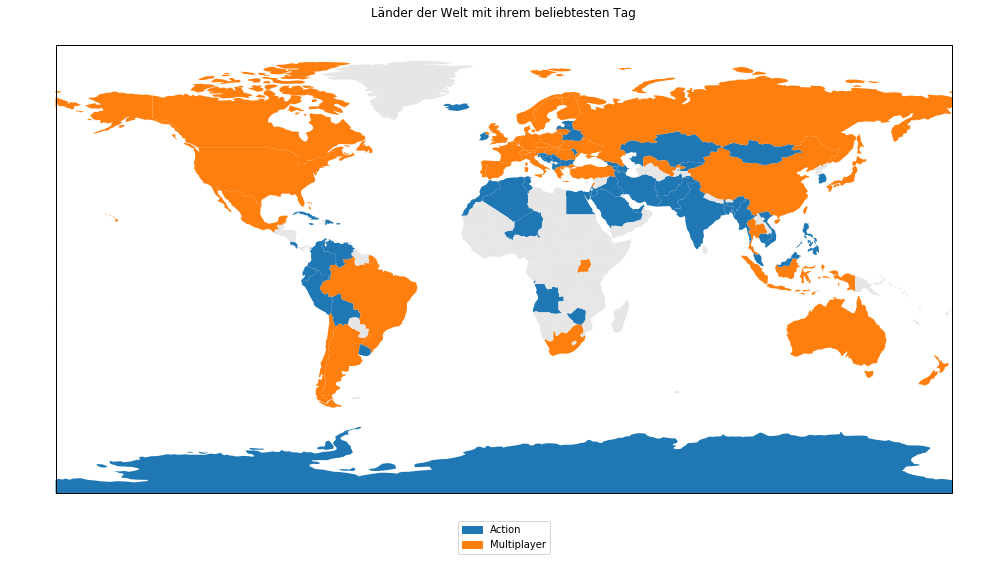

In [12]:
from matplotlib import cm
colors = {name:cm.tab10(i) for i, name in enumerate(unique_values)}

names_map = {'Bahamas':'Bahamas the', 'Republic of Korea':'Korea', 'Kyrgyzstan':'Kyrgyz Republic', 'Russian Federation':'Russia'}


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import patches
import cartopy.io.shapereader as shpreader
import itertools
import numpy as np

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                        category='cultural', name=shapename)

plt.figure(figsize=(14,10))
ax = plt.axes(projection=ccrs.PlateCarree())
for country in shpreader.Reader(countries_shp).records():
    country_name = country.attributes['NAME_LONG']
    if country_name in names_map.keys():
        country_name = names_map[country_name]
    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=colors[df_best_tags.loc[country_name]] if country_name in df_best_tags.index else [0.9, 0.9, 0.9],
                      label=country.attributes['NAME_LONG'])

patches = [patches.Patch(color=color, label=game) for game, color in colors.items()]
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0))

plt.title('Länder der Welt mit ihrem beliebtesten Tag')
plt.tight_layout()
plt.savefig('Grafiken/19_Länder_mit_beliebtestem_Tag.pdf')
plt.show()

df_best_tags.sort_index().to_csv('Tabellen/19_Länder_mit_beliebtestem_Tag.csv')

# Tag Evolution

In [13]:
df_country.head()

,App_ID,Country,Rank,Name,Player_Percentage_2_Weeks,Average_Hours_2_Weeks,Players_Percentage_Total,Average_Hours_Total,Library_Share
date,,,,,,,,,
2017-11-01,578080,United States,1,PLAYERUNKNOWN'S BATTLEGROUNDS,0.1993,835,0.1294,5945,0.002746
2017-11-01,730,United States,2,Counter-Strike: Global Offensive,0.1898,679,0.3134,17238,0.006785
2017-11-01,440,United States,3,Team Fortress 2,0.0697,638,0.4428,8037,0.009296
2017-11-01,230410,United States,4,Warframe,0.0670,1173,0.1463,5680,0.004013
2017-11-01,252950,United States,5,Rocket League,0.0622,628,0.1145,5855,0.002533


In [14]:
df_tags = df_country.groupby(['Country', 'Name']).agg('mean')['App_ID'].reset_index().merge(df_tags, right_on='appid', left_on='App_ID', how='outer')
df_tags.head(2)

,Country,Name,App_ID,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,appid,e-sports
0,Afghanistan,7 Days to Die,251570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2461.0,251570.0,0.0
1,Aland Islands,7 Days to Die,251570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2461.0,251570.0,0.0


In [15]:
df_tags.shape

(61830, 339)